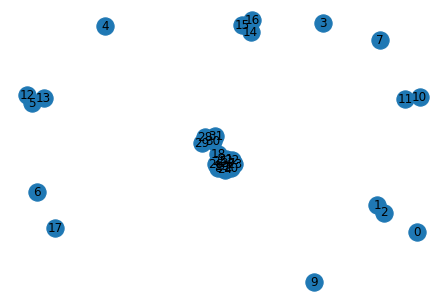

In [350]:
# libraries import
import os
import re
import json
import random
import itertools
import numpy as np
import networkx as nx
from scipy.stats import bernoulli

# fetching all the files
base_path = 'sequences/'
files = os.listdir(base_path)

# creating the Graph using networkx
G = nx.Graph()
node_index = 0

# main loop for graph construction
i = 0 # testing with just 1000 files
#for file in files:
while i < 50:
    # opening current file
    # print(files[i])
    with open(base_path + files[i]) as in_file:
        data = json.load(in_file)
    i += 1
    # isolating the comment section
    if 'comment' in data['results'][0]:
        comments_section = data['results'][0]['comment']

        # isolating the authors
        authors = []
        for comment in comments_section:
            pattern = '(_([a-zA-Z]+\.?\s?)*_)'
            results = re.findall(pattern, comment)
            if results:
                author = results[0][0].split('_')[1]
                authors.append(author)

        # adding the nodes
        for author in authors:
            if author not in nx.get_node_attributes(G, 'name').values():
                G.add_node(node_index, name = author)
                node_index += 1

        # adding the edges
        for pair in itertools.combinations(authors, 2):
            # fetching node 1
            node_1_key = list(nx.get_node_attributes(G, 'name').values()).index(pair[0])
            # fetching node 2
            node_2_key = list(nx.get_node_attributes(G, 'name').values()).index(pair[1])
            # adding the edge if it isn't already in the graph
            if (node_1_key, node_2_key) not in list(G.edges):
                G.add_edge(node_1_key, node_2_key)

nx.draw(G, with_labels = True)

Greedy algorithm O(m) for finding a MIS

In [351]:
def greedy_MIS(G):
    V_set = list(G.nodes).copy()
    maximal_independent_set = []
    while len(V_set) > 0:
        node = random.choice(V_set)
        maximal_independent_set.append(node)
        V_set.remove(node)
        for adj_node in list(G.adj[node]):
            if adj_node in V_set:
                V_set.remove(adj_node)
    return maximal_independent_set

In [595]:
greedy_MIS(Gp)

[2, 0, 6]

Greedy algorithm O(m) for finding a MIS with the specified nodes in it

In [352]:
# function that returns a MIS with the specified nodes in it
def greedy_MIS_with_nodes_specified(G, chosen_nodes):
    V_set = list(G.nodes).copy()
    maximal_independent_set = []
    if check_if_set_is_IS(G, chosen_nodes):
        # inserting the chosen nodes and removing their adj list
        for node in chosen_nodes:
            maximal_independent_set.append(node)
            V_set.remove(node)
            for adj_node in list(G.adj[node]):
                if adj_node in V_set:
                    V_set.remove(adj_node)
        # main loop
        while len(V_set) > 0:
            node = random.choice(V_set)
            maximal_independent_set.append(node)
            V_set.remove(node)
            for adj_node in list(G.adj[node]):
                if adj_node in V_set:
                    V_set.remove(adj_node)
    return maximal_independent_set

In [594]:
greedy_MIS_with_nodes_specified(Gp, [0,2])

[0, 2, 8, 9]

Luby's algorithm O(logn) for finding a MIS

In [584]:
def luby_MIS(G):
    V_set = list(G.nodes).copy()
    E_set = list(G.edges).copy()
    maximal_independent_set = []
    while len(V_set) > 0:
        probability_dist = [1/(2*G.degree[node]) if G.degree[node] > 0 else 1 for node in V_set]
        marks = bernoulli.rvs(probability_dist, size = len(V_set))
        zip_iter = zip(V_set, marks)
        marked_nodes = dict(zip_iter)
        for edge in E_set:
            if edge[0] in marked_nodes and edge[1] in marked_nodes:
                if marked_nodes[edge[0]] == 1 and marked_nodes[edge[1]] == 1:
                    if G.degree[edge[0]] < G.degree[edge[1]]:
                        marked_nodes[edge[0]] = 0
                    elif G.degree[edge[0]] > G.degree[edge[1]]:
                        marked_nodes[edge[1]] = 0
                    else:
                        if edge[0] < edge[1]:
                            marked_nodes[edge[0]] = 0
                        else:
                            marked_nodes[edge[1]] = 0
        for node in V_set:
            if marked_nodes[node] == 1:
                maximal_independent_set.append(node)
        for node in maximal_independent_set:
            if node in V_set:
                V_set.remove(node)
            for adj_node in G.adj[node]:
                if adj_node in V_set:
                    V_set.remove(adj_node)
        for edge in E_set:
            if not(edge[0] in V_set and edge[1] in V_set):
                E_set.remove(edge)
    return maximal_independent_set

In [593]:
luby_MIS(Gp)

[4, 5, 6, 2]

Algorithm designed to find all MISs

In [355]:
# function that returns true if the set is independent (no 2 vertex build an edge of G)
def check_if_set_is_IS(G, IS):
    pairs = itertools.permutations(IS, 2)
    if any(pair in list(G.edges) for pair in pairs):
        return False
    else:
        return True

In [356]:
# function that returns true if the independent set is maximal (non-extendible)
def check_if_set_is_MIS(G, IS):
    nodes_without_IS = [node for node in list(G.nodes) if node not in IS]
    if any(is_node_addable_to_IS(G, IS, node) for node in nodes_without_IS):
        return False
    else:
        return True

In [357]:
# function that returns true if the node we're trying to add doesn't turn the set into
# a dependent set
def is_node_addable_to_IS(G, IS, new_node):
    if any(new_node in G.adj[node] for node in IS):
        return False
    else:
        return True

In [358]:
# function that returns a degeneracy ordering for the graph G
def get_degeneracy_ordering(G):
    deg_ordering = []
    graph = G.copy()
    degrees = dict(graph.degree)
    for i in range(graph.number_of_nodes()):
        min_degree_node = min(degrees, key = degrees.get)
        graph.remove_node(min_degree_node)
        del degrees[min_degree_node]
        deg_ordering.append(min_degree_node)
    return deg_ordering

In [359]:
# function that given a set A returns its minimum element according to the degeneracy 
# ordering provided
def get_minimum_elem_in_deg_ord(deg_ord, A):
    if None in A:
        return A[0]
    for node in deg_ord:
        if node in A:
            return node

In [360]:
# function that returns the complementary neighborhood of a specified node, that is all 
# the nodes that don't appear in its adjacency list. doesn't count duplicates.
def get_complementary_neighborhood(G, spec_node):
    compl_neighborhood = []
    for node in G.nodes:
        compl_neighborhood += [adj_node for adj_node in G.adj[node] if adj_node not in G.adj[spec_node] and adj_node != spec_node]
    return list(set(compl_neighborhood))

In [361]:
# function that returns the complementary neighborhood of a specified node set, that is all 
# the nodes that don't appear in the adjacency lists of the nodes in the set. doesn't count
# duplicates.
def get_set_complementary_neighborhood(G, A):
    compl_neighborhood = []
    for set_node in A:
        compl_neigh = get_complementary_neighborhood(G, set_node)
        compl_neighborhood.append(compl_neigh)
    if not compl_neighborhood:
        return []
    else:
        intersection = set.intersection(*map(set,compl_neighborhood))
        return list(intersection)

In [362]:
# function that returns the neighbors of the nodes that come before the specified node
# in the degeneracy ordering
def get_neighbors_of_node_before_deg_ord(G, deg_ord, v):
    neighbors = set(G.adj[v])
    deg_ord_before_v = set(deg_ord[:deg_ord.index(v)])
    return list(set.intersection(neighbors, deg_ord_before_spec))

In [363]:
# function that returns the intersection between the specified set A and the nodes that 
# appear before the specified node in the degeneracy order
def get_nodes_in_set_before_spec_deg_ord(deg_ord, A, spec_node):
    deg_ord_before_spec = deg_ord[:deg_ord.index(spec_node)]
    A_before_spec = [node for node in deg_ord_before_spec if node in A]
    return A_before_spec

In [364]:
# function that returns the intersection between the specified set A and the nodes that 
# appear before the specified node or at the specified node in the degeneracy order
def get_nodes_in_set_before_equal_spec_deg_ord(deg_ord, A, spec_node):
    deg_ord_before_spec = deg_ord[:deg_ord.index(spec_node)+1]
    A_before_spec = [node for node in deg_ord_before_spec if node in A]
    return A_before_spec

In [365]:
# function that returns the intersection between the specified set A and the nodes that 
# appear after the specified node in the degeneracy order
def get_nodes_in_set_after_spec_deg_ord(deg_ord, A, spec_node):
    deg_ord_before_spec = deg_ord[deg_ord.index(spec_node):]
    A_before_spec = [node for node in deg_ord_before_spec if node in A]
    return A_before_spec

In [366]:
# function that returns the set I<v intersected with the complementary neighborhood of v,
# that is I'v
def get_I_prime_set(G, deg_ord, IS, v):
    I_before_v = get_nodes_in_set_before_spec_deg_ord(deg_ord, IS, v)
    compl_neighborhood_v = get_complementary_neighborhood(G, v)
    I_prime_v = [node for node in I_before_v if node in compl_neighborhood_v]
    return I_prime_v

In [367]:
# function that returns true whether the specified IS is root in the solution digraph
def is_root(G, IS, deg_ord):
    min_IS = get_minimum_elem_in_deg_ord(IS, deg_ord)
    PI_IS = get_parent_index(G, IS, deg_ord)
    return min_IS == PI_IS

In [368]:
def parent_state(G, IS, deg_ord):
    v = get_parent_index(G, IS, deg_ord)
    I_before_v = get_nodes_in_set_before_spec_deg_ord(deg_ord, IS, v)
    compl = complete_MIS(G, I_before_v, deg_ord)
    return compl, v

In [499]:
def get_next_candidate_ms(G, IS, deg_ord, v, nodes_checked):
    diff_V_IS = [node for node in G.nodes if node not in IS and node not in nodes_checked]
    diff_after_v = get_nodes_in_set_after_spec_deg_ord(deg_ord, diff_V_IS, v)
    return get_minimum_elem_in_deg_ord(deg_ord, diff_after_v)

In [371]:
def get_next_candidate(G, IS, deg_ord, v):
    smallest = None
    candidates = []
    for node in IS:
        compl_neighborhood = get_complementary_neighborhood(G, node)
        compl_neigh_after_node = get_nodes_in_set_after_spec_deg_ord(deg_ord, compl_neighborhood, node)
        compl_neigh_after_node_f = [node for node in compl_neigh_after_node if node not in IS]
        compl_neigh_after_node_filter = [node for node in compl_neigh_after_node_f if get_minimum_elem_in_deg_ord(deg_ord, [node, v]) == v]
        candidates += [node for node in compl_neigh_after_node_filter if node not in candidates]
    return get_minimum_elem_in_deg_ord(deg_ord, candidates)

In [471]:
def complete_MIS(G, IS, deg_ord):
    V_set = get_set_complementary_neighborhood(G, IS)
    while len(V_set) > 0:
        node = get_minimum_elem_in_deg_ord(deg_ord, V_set)
        IS.append(node)
        V_set.remove(node)
        for adj_node in list(G.adj[node]):
            if adj_node in V_set:
                V_set.remove(adj_node)
    return IS

In [373]:
def get_parent_index(G, IS, deg_ord):
    smallest = None
    candidates = []
    for node in IS:
        before_equal_set = get_nodes_in_set_before_equal_spec_deg_ord(deg_ord, IS, node)
        if set(complete_MIS(G, before_equal_set, deg_ord)) == set(IS):
            candidates.append(node)
    return get_minimum_elem_in_deg_ord(deg_ord, candidates)

In [374]:
def child_exist_ms(G, IS, deg_ord, v):
    I_prime_v = get_I_prime_set(G, deg_ord, IS, v)
    compl_neighborhood_I_prime_v = get_set_complementary_neighborhood(G, I_prime_v + [v])
    min_elem_compl_neigh = get_minimum_elem_in_deg_ord(deg_ord, compl_neighborhood_I_prime_v)
    if not get_minimum_elem_in_deg_ord(deg_ord, [min_elem_compl_neigh, v]) == v:
        return False
    while get_set_complementary_neighborhood(G, I_prime_v):
        x = get_minimum_elem_in_deg_ord(deg_ord, get_set_complementary_neighborhood(G, I_prime_v))
        if x in get_nodes_in_set_before_spec_deg_ord(deg_ord, IS, v):
            I_prime_v.append(x)
        else:
            return x in IS

In [510]:
G = Gp
G_ord = Gp_ord
set_of_found_MIS = []
for node in G_ord:
    root = complete_MIS(G, [node], G_ord)
    print('root:', root)
    if set(root) not in [set(MIS) for MIS in set_of_found_MIS]:
        set_of_found_MIS.append(root)
    my_iterative_spawn(G, root, G_ord, set_of_found_MIS)
print(set_of_found_MIS)

root: [9, 8, 2, 0]
[] [9, 8, 2, 0] 7
found: [8, 7, 4, 1]
[] [8, 7, 4, 1] 6
found: [7, 6, 4]
[] [7, 6, 4] 5
found: [6, 5, 4, 2]
[] [6, 5, 4, 2] 3
no child with 3
done with [6, 5, 4, 2]
[] [7, 8, 4, 1] 6
done with [7, 6, 4]
[] [8, 9, 2, 0] 7
done with [8, 7, 4, 1]
[] [] 9
done with []
root: [8, 9, 2, 0]
[] [8, 9, 2, 0] 7
done with [8, 7, 4, 1]
[] [] 9
done with []
root: [7, 8, 4, 1]
[] [7, 8, 4, 1] 6
done with [7, 6, 4]
[] [8, 9, 2, 0] 7
done with [8, 7, 4, 1]
[] [] 9
done with []
root: [6, 7, 4]
[] [6, 7, 4] 5
done with [6, 5, 4, 2]
[] [7, 8, 4, 1] 6
done with [7, 6, 4]
[] [8, 9, 2, 0] 7
done with [8, 7, 4, 1]
[] [] 9
done with []
root: [5, 9, 3, 1]
[] [5, 9, 3, 1] 4
no child with 4
done with [5, 9, 3, 1]
root: [4, 8, 7, 1]
[] [4, 8, 7, 1] 6
done with [7, 6, 4]
[] [8, 9, 2, 0] 7
done with [8, 7, 4, 1]
[] [] 9
done with []
root: [3, 9, 5, 1]
[] [3, 9, 5, 1] 4
no child with 4
done with [3, 9, 5, 1]
[] [] 9
done with []
root: [2, 9, 8, 0]
[] [2, 9, 8, 0] 7
done with [8, 7, 4, 1]
[] [] 9
do

In [509]:
def my_iterative_spawn(G, IS, deg_ord, set_of_found_MIS):
    v = get_parent_index(G, IS, deg_ord)
    paths_checked = []
    while True:
        childless = True
        nodes_checked = []
        while get_next_candidate_ms(G, IS, deg_ord, v, nodes_checked) is not None and set(IS) not in [set(IS) for IS in paths_checked]:
            v = get_next_candidate_ms(G, IS, deg_ord, v, nodes_checked)
            print(nodes_checked, IS, v)
            if not get_minimum_elem_in_deg_ord(deg_ord, [v, get_parent_index(G, IS, deg_ord)]) == v:
                if child_exist_ms(G, IS, deg_ord, v):
                    I_prime_v = get_I_prime_set(G, deg_ord, IS, v)
                    I_prime_before_v = get_nodes_in_set_before_spec_deg_ord(deg_ord, I_prime_v, v)
                    if v not in I_prime_before_v:
                        I_prime_before_v.append(v)
                    IS = complete_MIS(G, I_prime_before_v, deg_ord)
                    if set(IS) not in [set(MIS) for MIS in set_of_found_MIS]:
                        print('found:', IS)
                        set_of_found_MIS.append(IS)
                        childless = False
                        break
                else:
                    print('no child with', v)
                    nodes_checked.append(v)
            print('done with', IS)
            paths_checked.append(IS)
        if childless:
            if is_root(G, IS, deg_ord):
                return
            elif set(IS) in [set(IS) for IS in paths_checked]:
                parent, v_parent = parent_state(G, IS, deg_ord)
                IS, v = parent_state(G, parent, deg_ord)
            else:
                IS, v = parent_state(G, IS, deg_ord)
                print('restoring', IS, v)

In [438]:
def wrap_iterative_spawn(G, mode):
    set_of_found_MIS = []
    deg_ord = get_degeneracy_ordering(G)
    for node in list(G.nodes):
        root = complete_MIS(G, [node], deg_ord)
        print('root:', root)
        if set(root) not in [set(MIS) for MIS in set_of_found_MIS]:
            set_of_found_MIS.append(root)
        iterative_spawn(G, root, deg_ord, set_of_found_MIS)
    if mode == 'all':
        return set_of_found_MIS
    else:
        return max(set_of_found_MIS, key = len)

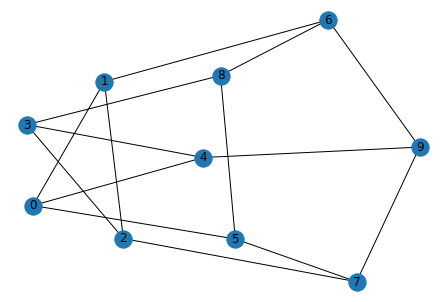

In [382]:
Gp = nx.petersen_graph()
nx.draw(Gp, with_labels = True)
deg_ordering = get_degeneracy_ordering(Gp)
Gp_ord = deg_ordering[::-1]

In [383]:
[[0, 2, 6],
 [0, 2, 8, 9],
 [0, 3, 6, 7],
 [0, 3, 9],
 [0, 7, 8],
 [1, 3, 5, 9],
 [1, 3, 7],
 [1, 4, 5],
 [1, 4, 7, 8],
 [1, 8, 9],
 [2, 4, 5, 6],
 [2, 4, 8],
 [2, 5, 9],
 [3, 5, 6],
 [4, 6, 7]]
Ij = [0,2,6]
parent_Ij = complete_MIS(Gp, get_nodes_in_set_before_spec_deg_ord(deg_ord, Ij, get_parent_index(Gp, Ij, deg_ord)), deg_ord)
Ii = parent_Ij
v = get_parent_index(Gp, Ij, deg_ord)
# formula 1:
i_prime = get_I_prime_set(Gp, deg_ord, Ij, v)
i_prime_before = get_nodes_in_set_before_spec_deg_ord(deg_ord, i_prime, v)
complete_MIS(Gp, i_prime_before + [v], deg_ord)

[6, 2, 0]

In [597]:
def find_all_MIS_rec(G, node, V_set, adj_V_set, remaining_nodes, set_of_found_MIS):
    if set(remaining_nodes) == set():
        return
    V_set.append(node)
    remaining_nodes.remove(node)
    for adj_node in G.adj[node]:
        if adj_node in remaining_nodes:
            remaining_nodes.remove(adj_node)
        if adj_node not in adj_V_set:
            adj_V_set.append(adj_node)
    if check_if_set_is_MIS(G, V_set):
        new_MIS = V_set.copy()
        if set(new_MIS) not in [set(MIS) for MIS in set_of_found_MIS]:
            set_of_found_MIS.append(new_MIS)
        V_set.remove(node)
    if set(V_set + remaining_nodes) not in [set(MIS) for MIS in set_of_found_MIS]:
        for rem_node in remaining_nodes:
            if is_node_addable_to_IS(G, V_set, rem_node):
                find_all_MIS_rec(G, rem_node, V_set.copy(), adj_V_set.copy(), remaining_nodes.copy(), set_of_found_MIS)

In [600]:
def find_all_MIS(G, mode):
    set_of_found_MIS = []
    V_set = []
    remaining_nodes = list(G.nodes).copy()
    for node in remaining_nodes:
        if G.degree[node] == 0:
            V_set.append(node)
    for node in V_set:
        remaining_nodes.remove(node)
    for node in remaining_nodes:
        adj_V_set = []
        if is_node_addable_to_IS(G, V_set, node):
            find_all_MIS_rec(G, node, V_set.copy(), adj_V_set.copy(), remaining_nodes.copy(), set_of_found_MIS)
    if mode == 'all':
        return set_of_found_MIS
    else:
        return max(set_of_found_MIS, key = len)

In [602]:
%%time
find_all_MIS(Gp, 'all')

CPU times: user 11.1 ms, sys: 215 µs, total: 11.3 ms
Wall time: 11.1 ms


[[0, 2, 6],
 [0, 2, 8, 9],
 [0, 3, 6, 7],
 [0, 3, 9],
 [0, 7, 8],
 [1, 3, 5, 9],
 [1, 3, 7],
 [1, 4, 5],
 [1, 4, 7, 8],
 [1, 8, 9],
 [2, 4, 5, 6],
 [2, 4, 8],
 [2, 5, 9],
 [3, 5, 6],
 [4, 6, 7]]

In [601]:
find_all_MIS(Gp, 'maximum')

[0, 2, 8, 9]